In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

from midvoxio.voxio import vox_to_arr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
blood_mask = vox_to_arr('../experiment_files/images/blood.vox')
myocardium_mask = vox_to_arr('../experiment_files/images/myocardium.vox')
blood_mask = np.where(np.sum(blood_mask, axis=-1) > 0, 1, 0)
myocardium_mask = np.where(np.sum(myocardium_mask, axis=-1) > 0, 1, 0)

In [ ]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
                               matrix_dims = (256,256,256),
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1592, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

test_phantom.add_tissue(fat, mask=np.ones((256,256,256)))
test_phantom.add_tissue(myocardium, mask=myocardium_mask)
test_phantom.add_tissue(blood, mask=blood_mask)
test_phantom.set_default_tissue('fat')
# plt.imshow(test_phantom.get_complete()[0,:,:,80])
# test_phantom.save('../experiment_files/cardiac_phantom')
# utils.save_mrc(test_phantom.get_complete(), '../experiment_files/cardiac_phantom/cardiac_phantom.mrc')

In [ ]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [ ]:
transducers = [transducer.Focused(max_frequency = 2e6,
                                  elements = 64, 
                                  width = 10e-3,
                                  height =  10e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 32, 
                                  imaging_ndims = 2,
                                  focus_azimuth = 50e-3,
                                  focus_elevation = 50e-3,
) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

In [ ]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.28,-np.pi*0.18,-np.pi*0.05], [-.055,0.04,-0.062]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.3,-np.pi*0.15,-np.pi*0.05], [-.06,0.06,-0.065]))

# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*3/20,np.pi/6,0], [-0.07,0.03,0.05]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [ ]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [ ]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,40e-3,40e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [ ]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/cardiac_experiment_04',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [ ]:
test_experiment.plot_ray_path(0)

In [ ]:
test_experiment.plot_ray_path(8)

In [ ]:
test_experiment.plot_ray_path(15)

In [2]:
test_experiment = experiment.Experiment.load('../experiment_files/cardiac_experiment_04')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


In [3]:
test_experiment.run(repeat=False)

Found no more simulations to run.


In [4]:
test_experiment.add_results()

In [5]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [6]:
# test_reconstruction.plot_ray_path(0)

In [ ]:
# test_reconstruction.plot_scatter()

In [7]:
image, signals = test_reconstruction.get_image(dimensions=3, matsize=100, downsample=0.05, workers=1)

multiproc time 0.1598656177520752


100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


In [21]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=256, downsample=1, workers=1)

multiproc time 0.06415128707885742


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


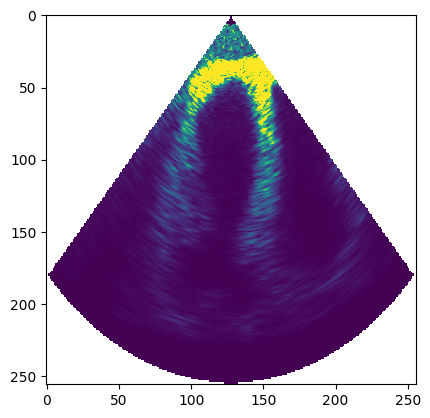

In [36]:
plt.imshow(signals[0], vmin=0, vmax=15000)

In [8]:
image.shape

(100, 100, 100)

In [9]:
image = np.where(np.isnan(image), 0, image)

In [10]:
np.sum(image)

1241828702.3194883

In [11]:
utils.save_mrc(image, '../experiment_files/cardiac_experiment_04/image.mrc')

In [ ]:
X = np.linspace(-1, 1, 256)
Y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(2,4, figsize=(10,5))
ax[0,0].pcolormesh(X, Y, signals[0], shading='auto', cmap='gray', norm='log')
# ax[0,1].pcolormesh(X, Y, signals[1], shading='auto', cmap='gray', norm='log')
# ax[0,2].pcolormesh(X, Y, signals[2], shading='auto', cmap='gray', norm='log')
# ax[0,3].pcolormesh(X, Y, signals[3], shading='auto', cmap='gray', norm='log')
# ax[1,0].pcolormesh(X, Y, signals[4], shading='auto', cmap='gray', norm='log')
# ax[1,1].pcolormesh(X, Y, signals[5], shading='auto', cmap='gray', norm='log')
# ax[1,2].pcolormesh(X, Y, signals[6], shading='auto', cmap='gray', norm='log')
# ax[1,3].pcolormesh(X, Y, signals[7], shading='auto', cmap='gray', norm='log')

for axd1 in ax:
    for a in axd1:
        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pcolormesh(X, Y, image, shading='auto', cmap='gray', norm='log')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1, 1)
image_rays = np.stack([np.mean(test_experiment.results[i][1], axis=0)[100:] for i in range(len(test_experiment.results))])
ax.pcolor(np.log(image_rays + 2))

In [ ]:
im = test_reconstruction.results[0][2]

In [ ]:
im2 = im.reshape((1232,112,-1))

In [ ]:
plt.imshow(im2)

In [ ]:
im.shape

In [ ]:
plt.imshow(im[:,:,300].T, cmap='bwr')

In [ ]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()

In [ ]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

def get_image(test_reconstruction, bounds=None, matsize=256, dimensions=3, downsample = 1, workers=8):
    assert dimensions in [2,3], print("Image can be 2 or 3 dimensional")
    assert (downsample > 0 and downsample <= 1), print("Downsample must be a float on (0,1]")
    
    times, coords, processed = test_reconstruction.preprocess_data(workers=workers)
    coords = np.stack(coords, axis=0)
    processed = np.stack(processed, axis=0)

    if bounds is None:
        flat_coords = coords.reshape(-1,3)
        bounds = np.array([(np.min(flat_coords[:,0]),np.max(flat_coords[:,0])),
                        (np.min(flat_coords[:,1]),np.max(flat_coords[:,1])),
                        (np.min(flat_coords[:,2]),np.max(flat_coords[:,2]))])
    elif type(bounds) == list or type(bounds) == tuple or type(bounds) == np.ndarray:
        bounds = np.array(bounds)
    elif type(bounds) == float:
        bounds = np.array([(-bounds,bounds),(-bounds,bounds),(-bounds,bounds)])
    else:
        print("provide bounds as a list, tuple, numpy array, or float")
        return 0

    X = np.linspace(bounds[0,0], bounds[0,1], matsize)
    Y = np.linspace(bounds[1,0], bounds[1,1], matsize)
    Z = np.linspace(bounds[2,0], bounds[2,1], matsize)
    
    if dimensions == 2:
        X, Y = np.meshgrid(X, Y, indexing='ij') # worked before changing indexing to ij so maybe take this out if it doesn't work anymore :/
    else:
        X, Y, Z = np.meshgrid(X, Y, Z, indexing='ij')

    signals = []
    count = 0
    for transducer in tqdm.tqdm(test_reconstruction.transducer_set.transducers):
        subset_coords = coords[count:(count+transducer.get_num_rays()),:].reshape(-1,3)
        subset_processed = processed[count:(count+transducer.get_num_rays())].reshape(-1)
        
        if downsample != 1:
            subset_coords = subset_coords[::int(1/downsample)]
            subset_processed = subset_processed[::int(1/downsample)]
                        
        if dimensions == 2:
            interp = NearestNDInterpolator(subset_coords[:,:2], subset_processed)
            signals.append(interp(X, Y))
        else:
            interp = NearestNDInterpolator(subset_coords, subset_processed)
            signals.append(interp(X, Y, Z))
        count += transducer.get_num_rays()
    
    combined_signals = np.stack(signals, axis=0)
    masked_signals = np.ma.masked_array(combined_signals, np.isnan(combined_signals))
    image = np.ma.average(masked_signals, axis=0)
    image = image.filled(np.nan)
    
    return image, signals, coords

In [ ]:
image, signals, coords = get_image(test_reconstruction, dimensions=3, matsize=100, downsample=0.05, workers=1)

In [ ]:
np.sum(np.where(np.isnan(image), 0, image))

In [ ]:
coords.shape